In [20]:
library(ggplot2)
library(tidyverse)
library(MASS)
library(janitor)
library(dplyr)
library(pROC)

In [21]:
undersampling_data <- read.csv(file = "../data/undersampled_data.csv")
oversampling_data <- read.csv(file = "../data/oversampled_data.csv")
smote_data <- read.csv(file = "../data/smote_augmented_data_80_percent.csv")

In [22]:
glimpse(undersampling_data|>clean_names())

Rows: 13,893
Columns: 22
$ diabetes_012           <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,~
$ high_bp                <dbl> 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,~
$ high_chol              <dbl> 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,~
$ chol_check             <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,~
$ bmi                    <dbl> 24, 32, 28, 28, 35, 27, 43, 47, 34, 33, 31, 32,~
$ smoker                 <dbl> 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,~
$ stroke                 <dbl> 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,~
$ heart_diseaseor_attack <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,~
$ phys_activity          <dbl> 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,~
$ fruits                 <dbl> 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0,~
$ veggies                <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1,~
$ hvy_alcohol_consump    <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,~
$ any_healthcar

## Data Preprocessing

In [23]:
process_data <- function(data) {
  # Clean column names
  data <- clean_names(data)
  
  # Hàm để phân loại BMI
  categorize_bmi <- function(bmi) {
    if (bmi < 18.5) {
      return('Underweight')
    } else if (bmi >= 18.5 & bmi < 24.9) {
      return('Normal weight')
    } else if (bmi >= 25 & bmi < 29.9) {
      return('Overweight')
    } else if (bmi >= 30 & bmi < 34.9) {
      return('Obesity class 1')
    } else if (bmi >= 35 & bmi < 39.9) {
      return('Obesity class 2')
    } else {
      return('Obesity class 3')
    }
  }
  
  # Tạo cột mới bmi_category cho dataframe data
  data$bmi_category <- sapply(data$bmi, categorize_bmi)
  # Chuyển đổi bmi_category thành factor với các levels cụ thể
  data$bmi_category <- factor(data$bmi_category, levels = c('Underweight', 'Normal weight', 'Overweight', 'Obesity class 1', 'Obesity class 2', 'Obesity class 3'))
  

  # Xóa các cột không cần thiết
  data <- within(data, rm("bmi", "ment_hlth"))
  
  # Chuyển đổi các biến không định lượng thành factor
  quantitative_vars <- c("phys_hlth")

  non_quantitative_vars <- setdiff(names(data), quantitative_vars)
  data[non_quantitative_vars] <- lapply(data[non_quantitative_vars], factor)
  
  return(data)
}

Your code contains a unicode char which cannot be displayed in your
current locale and R will silently convert it to an escaped form when the
R kernel executes this code. This can lead to subtle errors if you use
such chars to do comparisons. For more information, please see
https://github.com/IRkernel/repr/wiki/Problems-with-unicode-on-windows

In [24]:
undersampling_data <- process_data(undersampling_data)
oversampling_data <- process_data(oversampling_data)
smote_data <- process_data(smote_data)

In [25]:
glimpse(undersampling_data)

Rows: 13,893
Columns: 21
$ diabetes_012           <fct> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,~
$ high_bp                <fct> 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,~
$ high_chol              <fct> 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,~
$ chol_check             <fct> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,~
$ smoker                 <fct> 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,~
$ stroke                 <fct> 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,~
$ heart_diseaseor_attack <fct> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,~
$ phys_activity          <fct> 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,~
$ fruits                 <fct> 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0,~
$ veggies                <fct> 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1,~
$ hvy_alcohol_consump    <fct> 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,~
$ any_healthcare         <fct> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,~
$ no_docbc_cost

## Modeling

Hàm Cross Validation với K Folds = 5 cho LDA và QDA

In [26]:
# Hàm để chia train test theo tỷ lệ
# Hàm để chia train test theo tỷ lệ
train_test_split <- function(data, train_ratio = 0.8) {
    set.seed(123)  # Đặt seed để đảm bảo tính tái lập
    train_indices <- sample(seq_len(nrow(data)), size = floor(train_ratio * nrow(data)), replace = FALSE)
    train_data <- data[train_indices, ]
    test_data <- data[-train_indices, ]
    res <- list(
        train_data = train_data,
        test_data = test_data
    )
    return(res)
}

# Cross validation LDA
lda_cross_validate <- function(model_formula, data, k = 5) {
        set.seed(123) # Set seed for reproducibility
        
        # Create k-folds
        folds <- sample(rep(1:k, length.out = nrow(data)))
        
        # Initialize a list to store results and models
        results <- list()
        models <- list()
        
        # Perform cross-validation
        for (i in 1:k) {
                # Split data into training and testing sets
                train_data <- data[folds != i, ]
                test_data <- data[folds == i, ]
                
                # Train the model on the training set
                model <- lda(formula = model_formula, data = train_data)
                
                # Predict on the testing set
                predictions <- predict(model, test_data)$class
                
                # Calculate accuracy
                accuracy <- mean(predictions == test_data$diabetes_012)
                
                # Store the result and model
                results[[i]] <- accuracy
                models[[i]] <- model
        }
        
        return(list(models = models, results = results))
}

# Cross Validation QDA
qda_cross_validate <- function(model_formula, data, k = 5) {
        set.seed(123) # Set seed for reproducibility
        
        # Create k-folds
        folds <- sample(rep(1:k, length.out = nrow(data)))
        
        # Initialize a list to store results and models
        results <- list()
        models <- list()
        
        # Perform cross-validation
        for (i in 1:k) {
                # Split data into training and testing sets
                train_data <- data[folds != i, ]
                test_data <- data[folds == i, ]
                
                # Train the model on the training set
                model <- qda(formula = model_formula, data = train_data)
                
                # Predict on the testing set
                predictions <- predict(model, test_data)$class
                
                # Calculate accuracy
                accuracy <- mean(predictions == test_data$diabetes_012)
                
                # Store the result and model
                results[[i]] <- accuracy
                models[[i]] <- model
        }
        
        return(list(models = models, results = results))
}

Your code contains a unicode char which cannot be displayed in your
current locale and R will silently convert it to an escaped form when the
R kernel executes this code. This can lead to subtle errors if you use
such chars to do comparisons. For more information, please see
https://github.com/IRkernel/repr/wiki/Problems-with-unicode-on-windows

In [27]:
# Chia train test cho từng bộ dữ liệu
split_undersampling <- train_test_split(undersampling_data)
split_oversampling <- train_test_split(oversampling_data)
split_smote <- train_test_split(smote_data)

# Cross-validation trên tập train
lda_results_train_undersampling <- lda_cross_validate(diabetes_012 ~ ., split_undersampling$train_data)
qda_results_train_undersampling <- qda_cross_validate(diabetes_012 ~ ., split_undersampling$train_data)

lda_results_train_oversampling <- lda_cross_validate(diabetes_012 ~ ., split_oversampling$train_data)
qda_results_train_oversampling <- qda_cross_validate(diabetes_012 ~ ., split_oversampling$train_data)

lda_results_train_smote <- lda_cross_validate(diabetes_012 ~ ., split_smote$train_data)
qda_results_train_smote <- qda_cross_validate(diabetes_012 ~ ., split_smote$train_data)

# Tính độ chính xác trung bình trên tập train
lda_mean_accuracy_train_undersampling <- mean(unlist(lda_results_train_undersampling$results))
qda_mean_accuracy_train_undersampling <- mean(unlist(qda_results_train_undersampling$results))

lda_mean_accuracy_train_oversampling <- mean(unlist(lda_results_train_oversampling$results))
qda_mean_accuracy_train_oversampling <- mean(unlist(qda_results_train_oversampling$results))

lda_mean_accuracy_train_smote <- mean(unlist(lda_results_train_smote$results))
qda_mean_accuracy_train_smote <- mean(unlist(qda_results_train_smote$results))

# In ra độ chính xác trung bình trên tập train
print(paste("Mean LDA Accuracy on Train (Undersampling):", lda_mean_accuracy_train_undersampling))
print(paste("Mean QDA Accuracy on Train (Undersampling):", qda_mean_accuracy_train_undersampling))

print(paste("Mean LDA Accuracy on Train (Oversampling):", lda_mean_accuracy_train_oversampling))
print(paste("Mean QDA Accuracy on Train (Oversampling):", qda_mean_accuracy_train_oversampling))

print(paste("Mean LDA Accuracy on Train (SMOTE):", lda_mean_accuracy_train_smote))
print(paste("Mean QDA Accuracy on Train (SMOTE):", qda_mean_accuracy_train_smote))

# Lấy ra model có accuracy cao nhất
best_lda_model_undersampling <- lda_results_train_undersampling$models[[which.max(lda_results_train_undersampling$results)]]
best_qda_model_undersampling <- qda_results_train_undersampling$models[[which.max(qda_results_train_undersampling$results)]]

best_lda_model_oversampling <- lda_results_train_oversampling$models[[which.max(lda_results_train_oversampling$results)]]
best_qda_model_oversampling <- qda_results_train_oversampling$models[[which.max(qda_results_train_oversampling$results)]]

best_lda_model_smote <- lda_results_train_smote$models[[which.max(lda_results_train_smote$results)]]
best_qda_model_smote <- qda_results_train_smote$models[[which.max(qda_results_train_smote$results)]]

# Predict trên tập test
lda_predictions_test_undersampling <- predict(best_lda_model_undersampling, split_undersampling$test_data)$class
qda_predictions_test_undersampling <- predict(best_qda_model_undersampling, split_undersampling$test_data)$class

lda_predictions_test_oversampling <- predict(best_lda_model_oversampling, split_oversampling$test_data)$class
qda_predictions_test_oversampling <- predict(best_qda_model_oversampling, split_oversampling$test_data)$class

lda_predictions_test_smote <- predict(best_lda_model_smote, split_smote$test_data)$class
qda_predictions_test_smote <- predict(best_qda_model_smote, split_smote$test_data)$class

# Tính độ chính xác trên tập test
lda_accuracy_test_undersampling <- mean(lda_predictions_test_undersampling == split_undersampling$test_data$diabetes_012)
qda_accuracy_test_undersampling <- mean(qda_predictions_test_undersampling == split_undersampling$test_data$diabetes_012)

lda_accuracy_test_oversampling <- mean(lda_predictions_test_oversampling == split_oversampling$test_data$diabetes_012)
qda_accuracy_test_oversampling <- mean(qda_predictions_test_oversampling == split_oversampling$test_data$diabetes_012)

lda_accuracy_test_smote <- mean(lda_predictions_test_smote == split_smote$test_data$diabetes_012)
qda_accuracy_test_smote <- mean(qda_predictions_test_smote == split_smote$test_data$diabetes_012)

# In ra độ chính xác trên tập test
print(paste("LDA Accuracy on Test (Undersampling):", lda_accuracy_test_undersampling))
print(paste("QDA Accuracy on Test (Undersampling):", qda_accuracy_test_undersampling))

print(paste("LDA Accuracy on Test (Oversampling):", lda_accuracy_test_oversampling))
print(paste("QDA Accuracy on Test (Oversampling):", qda_accuracy_test_oversampling))

print(paste("LDA Accuracy on Test (SMOTE):", lda_accuracy_test_smote))
print(paste("QDA Accuracy on Test (SMOTE):", qda_accuracy_test_smote))

Your code contains a unicode char which cannot be displayed in your
current locale and R will silently convert it to an escaped form when the
R kernel executes this code. This can lead to subtle errors if you use
such chars to do comparisons. For more information, please see
https://github.com/IRkernel/repr/wiki/Problems-with-unicode-on-windows

[1] "Mean LDA Accuracy on Train (Undersampling): 0.525734030892968"
[1] "Mean QDA Accuracy on Train (Undersampling): 0.496759311558686"
[1] "Mean LDA Accuracy on Train (Oversampling): 0.532426246842315"
[1] "Mean QDA Accuracy on Train (Oversampling): 0.509578154965137"
[1] "Mean LDA Accuracy on Train (SMOTE): 0.549978518008474"
[1] "Mean QDA Accuracy on Train (SMOTE): 0.555544304897794"
[1] "LDA Accuracy on Test (Undersampling): 0.49730118747751"
[1] "QDA Accuracy on Test (Undersampling): 0.483267362360561"
[1] "LDA Accuracy on Test (Oversampling): 0.532278674657596"
[1] "QDA Accuracy on Test (Oversampling): 0.510222630167558"
[1] "LDA Accuracy on Test (SMOTE): 0.548701474002484"
[1] "QDA Accuracy on Test (SMOTE): 0.555918506920073"


Your code contains a unicode char which cannot be displayed in your
current locale and R will silently convert it to an escaped form when the
R kernel executes this code. This can lead to subtle errors if you use
such chars to do comparisons. For more information, please see
https://github.com/IRkernel/repr/wiki/Problems-with-unicode-on-windows

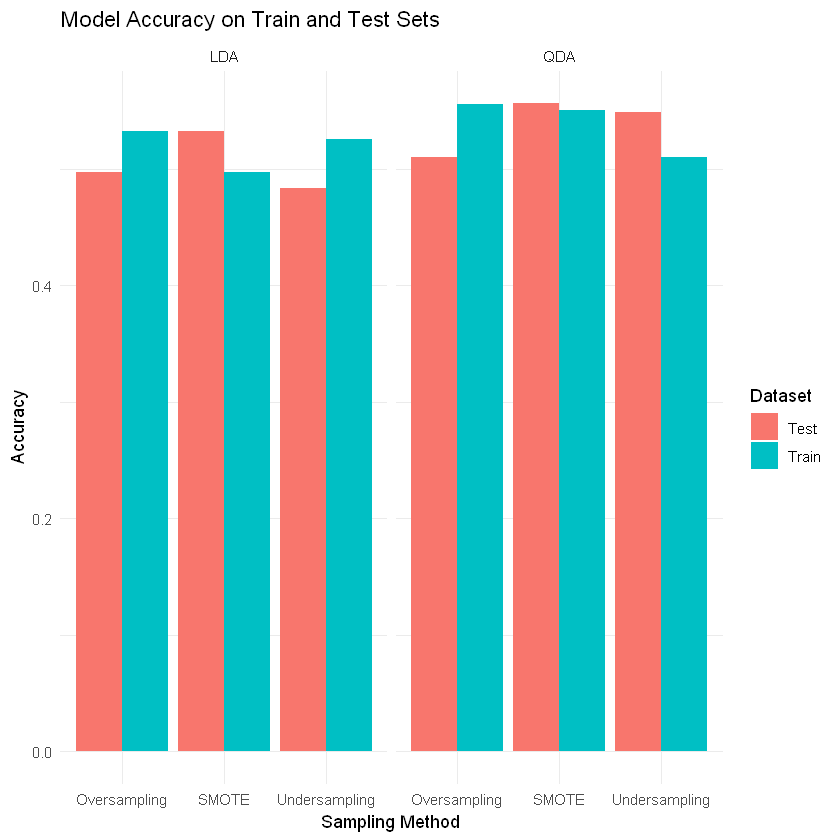

In [28]:
# Tạo dataframe chứa độ chính xác trên train và test
accuracy_data <- data.frame(
    Model = rep(c("LDA", "QDA"), each = 6),
    Sampling = rep(c("Undersampling", "Oversampling", "SMOTE"), times = 4),
    Dataset = rep(c("Train", "Test"), times = 6),
    Accuracy = c(
        lda_mean_accuracy_train_undersampling, lda_accuracy_test_undersampling,
        qda_mean_accuracy_train_undersampling, qda_accuracy_test_undersampling,
        lda_mean_accuracy_train_oversampling, lda_accuracy_test_oversampling,
        qda_mean_accuracy_train_oversampling, qda_accuracy_test_oversampling,
        lda_mean_accuracy_train_smote, lda_accuracy_test_smote,
        qda_mean_accuracy_train_smote, qda_accuracy_test_smote
    )
)

# Vẽ barplot
ggplot(accuracy_data, aes(x = Sampling, y = Accuracy, fill = Dataset)) +
    geom_bar(stat = "identity", position = "dodge") +
    facet_wrap(~ Model) +
    labs(title = "Model Accuracy on Train and Test Sets",
             x = "Sampling Method",
             y = "Accuracy") +
    theme_minimal()

In [29]:
library(caret)
library(ggplot2)
library(reshape2)

# Function to plot confusion matrix
plot_confusion_matrix <- function(predictions, actual, title) {
    cm <- confusionMatrix(predictions, actual)
    cm_table <- as.table(cm)
    cm_df <- as.data.frame(cm_table)
    colnames(cm_df) <- c("Prediction", "Actual", "Freq")
    
    ggplot(data = cm_df, aes(x = Prediction, y = Actual, fill = Freq)) +
        geom_tile() +
        geom_text(aes(label = Freq), vjust = 1) +
        scale_fill_gradient(low = "white", high = "blue") +
        labs(title = title, x = "Predicted", y = "Actual") +
        theme_minimal()
}

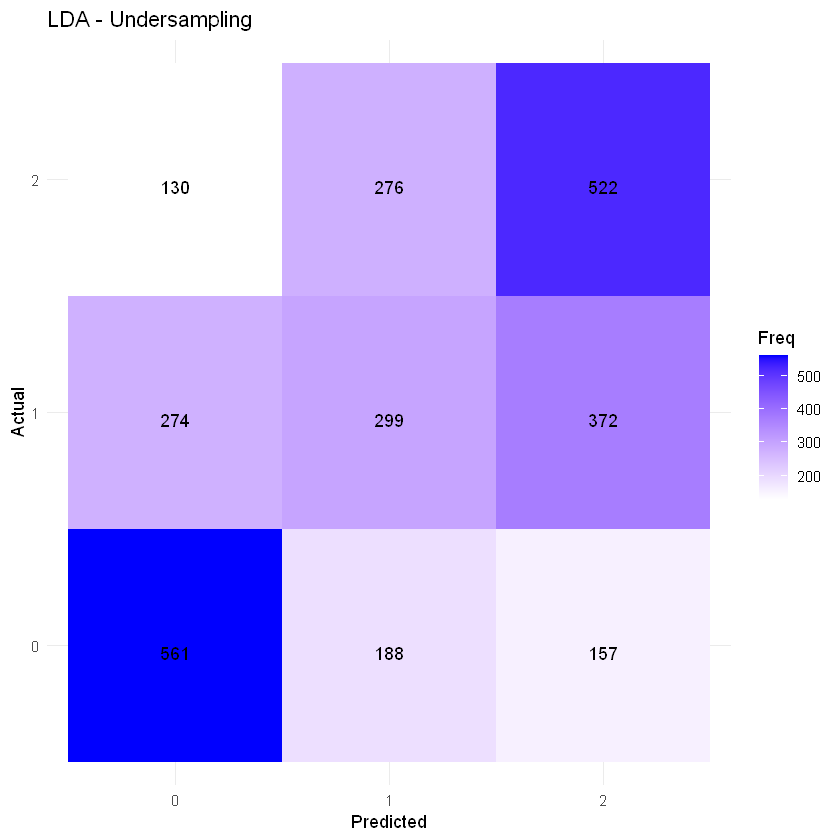

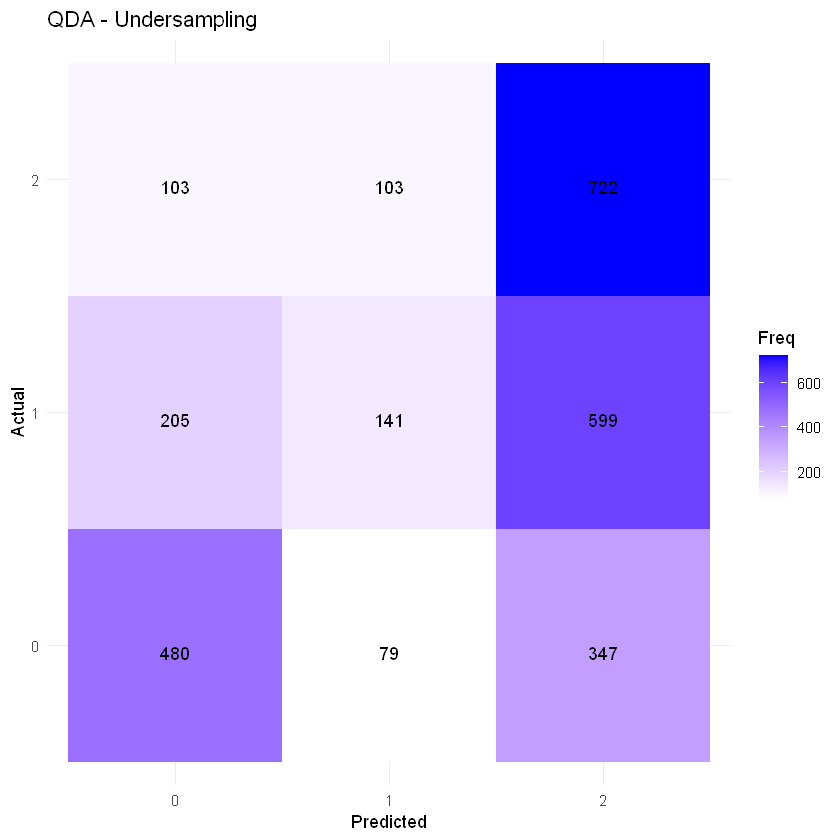

In [30]:
# Plot confusion matrix for LDA and QDA on undersampling data
plot_confusion_matrix(lda_predictions_test_undersampling, split_undersampling$test_data$diabetes_012, "LDA - Undersampling")
plot_confusion_matrix(qda_predictions_test_undersampling, split_undersampling$test_data$diabetes_012, "QDA - Undersampling")

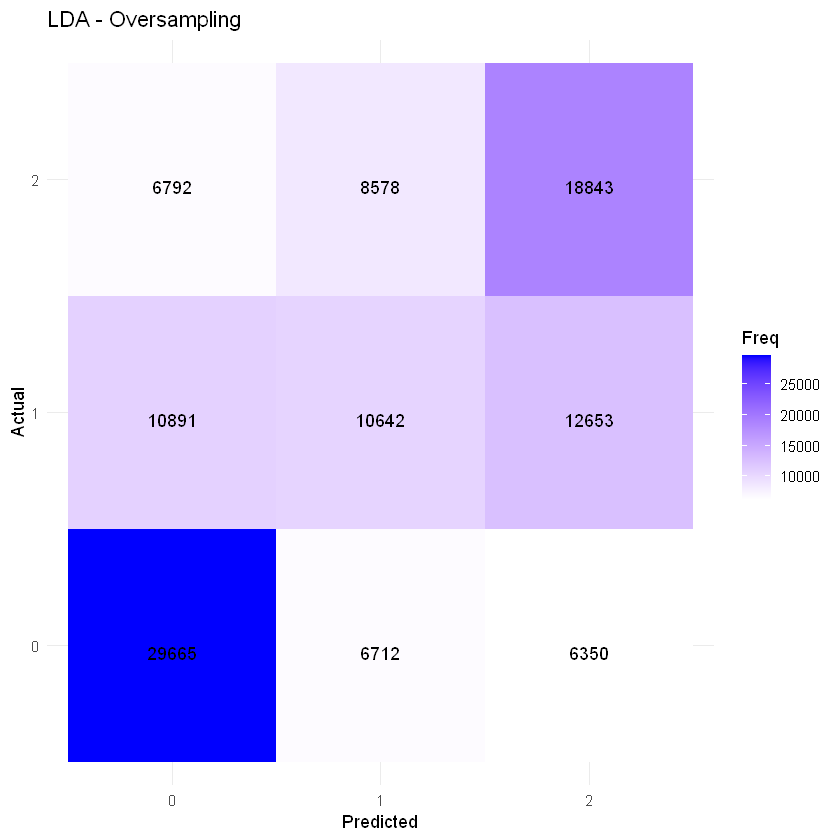

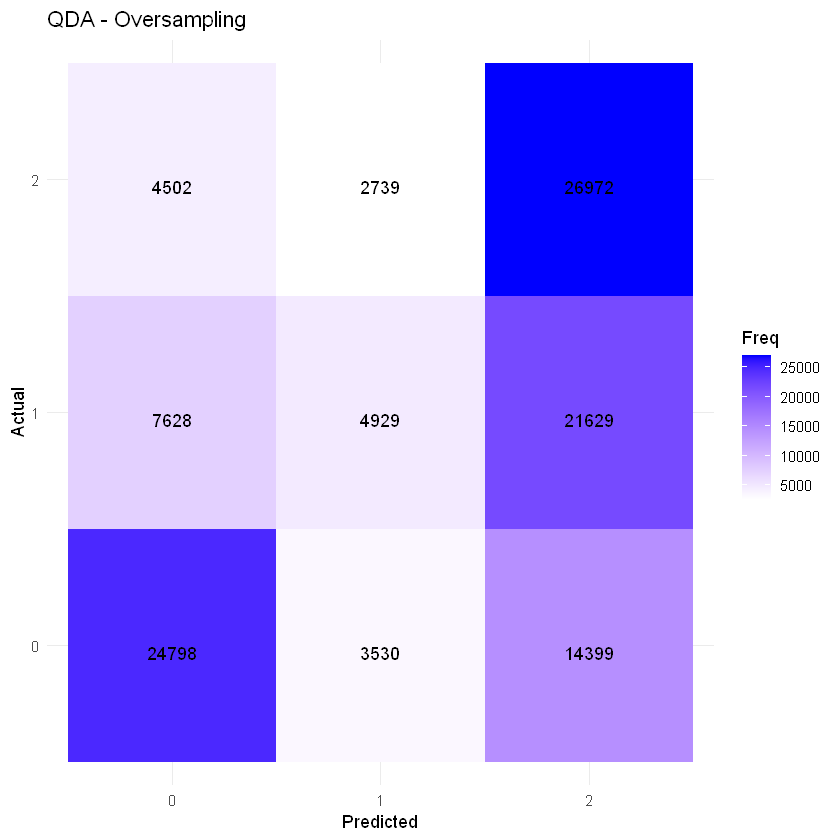

In [31]:
# Plot confusion matrix for LDA and QDA on oversampling data
plot_confusion_matrix(lda_predictions_test_oversampling, split_oversampling$test_data$diabetes_012, "LDA - Oversampling")
plot_confusion_matrix(qda_predictions_test_oversampling, split_oversampling$test_data$diabetes_012, "QDA - Oversampling")

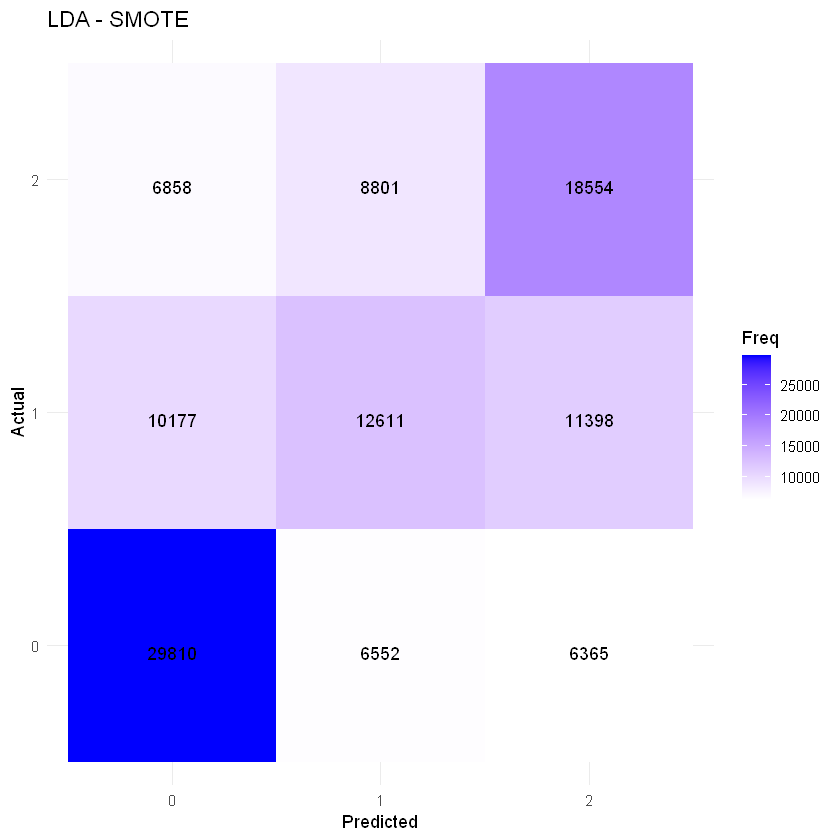

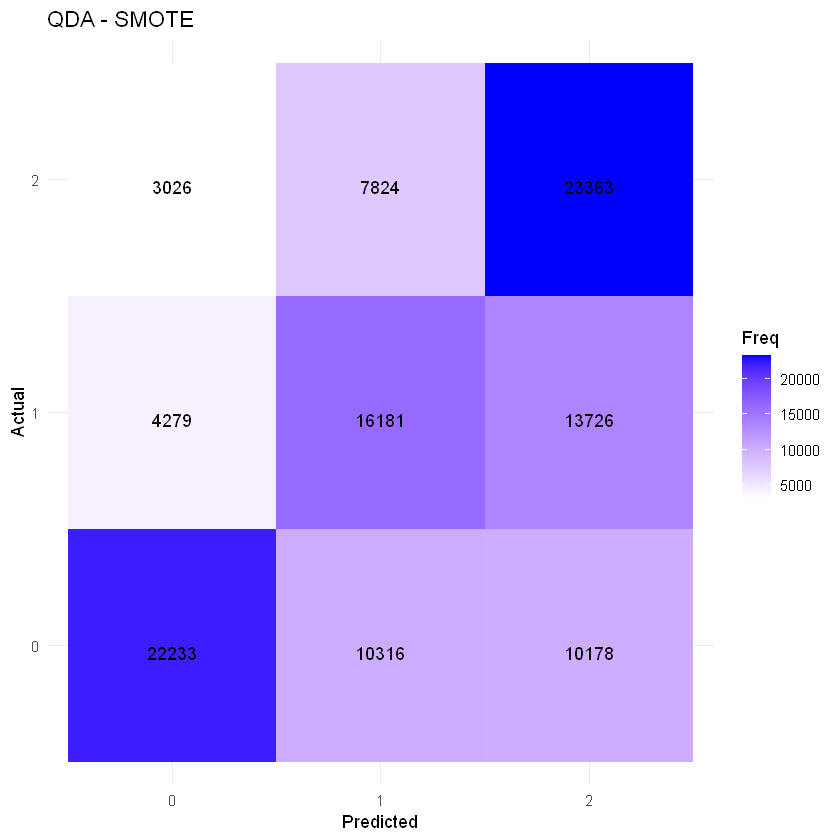

In [32]:
# Plot confusion matrix for LDA and QDA on SMOTE data
plot_confusion_matrix(lda_predictions_test_smote, split_smote$test_data$diabetes_012, "LDA - SMOTE")
plot_confusion_matrix(qda_predictions_test_smote, split_smote$test_data$diabetes_012, "QDA - SMOTE")